In [ ]:
#!pip install torchvision
import torchvision.datasets as datasets
import torch


In [ ]:
#!pip install gdown
#!pip install natsort
import os
import zipfile
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
## Setup
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Fetch data from Google Drive
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1CeCv8rlc7OT8MHMTSr_uzfdbKop1a7pa'

# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform
    self.image_names = natsorted(image_names)

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

## Load the dataset
# Path to directory with all the images
img_folder = f'{dataset_folder}/img_align_celeba'
# Spatial size of training images, images are resized to this size.
image_size = 64
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], #standarization of the data
                          std=[0.5, 0.5, 0.5])
])
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, transform)

## Create a dataloader
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1CeCv8rlc7OT8MHMTSr_uzfdbKop1a7pa
From (redirected): https://drive.google.com/uc?id=1CeCv8rlc7OT8MHMTSr_uzfdbKop1a7pa&confirm=t&uuid=4a02344b-4c80-459c-b87d-fe7ed2cbf557
To: /Users/sebastianhiguera/data/celeba/img_align_celeba.zip
100%|██████████████████████████████████████| 1.44G/1.44G [06:21<00:00, 3.78MB/s]


In [ ]:
from torch.utils.data import random_split

# Define the proportion or size of the test set
test_size = 0.2  # for example, 20% of the dataset
total_size = len(celeba_dataset)
test_size = int(test_size * total_size)
train_size = total_size - test_size

# Split the dataset
train_dataset, test_dataset = random_split(celeba_dataset, [train_size, test_size])

# Create DataLoaders for train and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [ ]:
#### Autoencoder structure #####
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: use two convolutional layers, which is a good option when dealing with images
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # [batch, 16, 32, 32]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)                      # [batch, 64, 10, 10]
        )

        # Decoder: reverse the decoding process, applying same layers but backwards
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),           # [batch, 32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # [batch, 16, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),   # [batch, 3, 64, 64]
            nn.Sigmoid()  # Using Sigmoid to scale the output to [0,1]
        )
# Now define the forward pass, applying the encoder and then the decoder to the data
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Autoencoder initialization
autoencoder = Autoencoder().to(device)

# Define the Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)



In [ ]:
### Train the autoencoder
num_epochs = 5  # Can be changed

for epoch in range(num_epochs):
    for data in train_loader:  # Iterate over each batch in the DataLoader
        img = data.to(device)  # Move the data to the device
        # Forward pass
        output = autoencoder(img)
        loss = criterion(output, img)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/2], Loss: 0.2503
Epoch [2/2], Loss: 0.2567


In [ ]:
### Evaluate autoencoder
with torch.no_grad():  # No need to track gradients
    for data in test_loader:
        img = data.to(device)
        output = autoencoder(img)
        # Compare output images with original images

Fontconfig warning: ignoring UTF-8: not a valid region tag


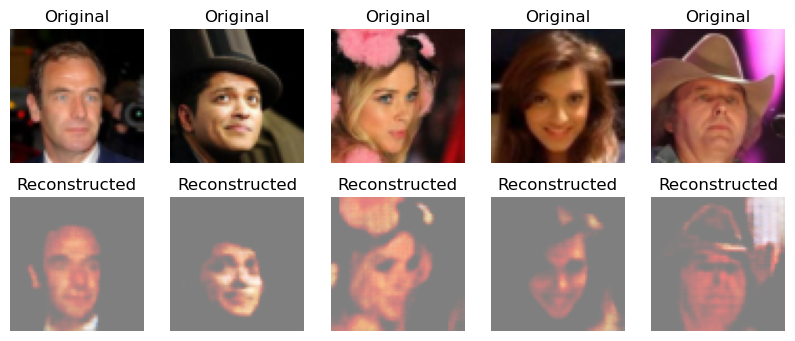

Average reconstruction error: 6.0968116286558865e-06


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert a tensor to a numpy image
def to_img(x):
    x = 0.5 * (x + 1)  # Unnormalize
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 64, 64)
    return x.detach().cpu().numpy()

# Switch model to evaluation mode
autoencoder.eval()

# Calculate the loss - here we're using MSE
mse_loss = nn.MSELoss()
total_loss = 0.0

# We'll also visualize some of the outputs
num_images_to_show = 5
fig, axes = plt.subplots(nrows=2, ncols=num_images_to_show, figsize=(10, 4))

# Use the first `num_images_to_show` images from the test_loader
for i, data in enumerate(test_loader):
    img = data.to(device)
    output = autoencoder(img)
    loss = mse_loss(output, img)
    total_loss += loss.item()

    # Only plot the first batch of images
    if i == 0:
        # Convert the images to a displayable format
        original_images = to_img(img)
        reconstructed_images = to_img(output)

        # Plot original and reconstructed images
        for k in range(num_images_to_show):
            axes[0, k].imshow(np.transpose(original_images[k], (1, 2, 0)))
            axes[0, k].set_title('Original')
            axes[0, k].axis('off')

            axes[1, k].imshow(np.transpose(reconstructed_images[k], (1, 2, 0)))
            axes[1, k].set_title('Reconstructed')
            axes[1, k].axis('off')

        plt.show()

        break  # We only want to visualize one batch

# Calculate the average loss per image
average_loss = total_loss / len(test_loader.dataset)
print(f'Average reconstruction error: {average_loss}')


In [ ]:
#### Now the Variational Autoencoder ######
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder is the same
        self.enc_conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(32, 64, 7)

        # This represents the fully connected layers that output the mean and log-variance, this is new!
        self.fc_mu = nn.Linear(in_features=64*10*10, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=64*10*10, out_features=latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(in_features=latent_dim, out_features=64*10*10)
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, 7)
        self.dec_conv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)
# Apply reparametrization trick
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = self.dec_fc(z)
        z = z.view(z.size(0), 64, 10, 10)  # Unflatten z to match the shape after the last conv layer in the encoder
        z = F.relu(self.dec_conv1(z))
        z = F.relu(self.dec_conv2(z))
        z = torch.sigmoid(self.dec_conv3(z))  # Sigmoid activation to get the output between 0 and 1
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# You also need to set latent_dim, which is a hyperparameter representing the size of the latent space
latent_dim = 80  # for example

# VAE initialization
vae = VAE().to(device)

# We modify the loss function to include the KL divergence

def loss_function(recon_x, x, mu, logvar):
    # Ensure the reconstructed output has the same shape as the input
    # Assuming the input x has a shape of [batch_size, channels, height, width]
    recon_x = recon_x.view_as(x)  # Reshape recon_x to have the same shape as x

    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# The optimizer stays the same
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# And the training loop changes to accommodate the VAE loss
for epoch in range(5):
    for data in train_loader:
        img = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{5}], Loss: {loss.item()/len(img):.4f}')


Epoch [1/2], Loss: 3327.0923
Epoch [2/2], Loss: 2997.2441
Epoch [3/2], Loss: 3245.6624
Epoch [4/2], Loss: 3393.1931
Epoch [5/2], Loss: 3035.0273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average MSE: 2935.053076171875


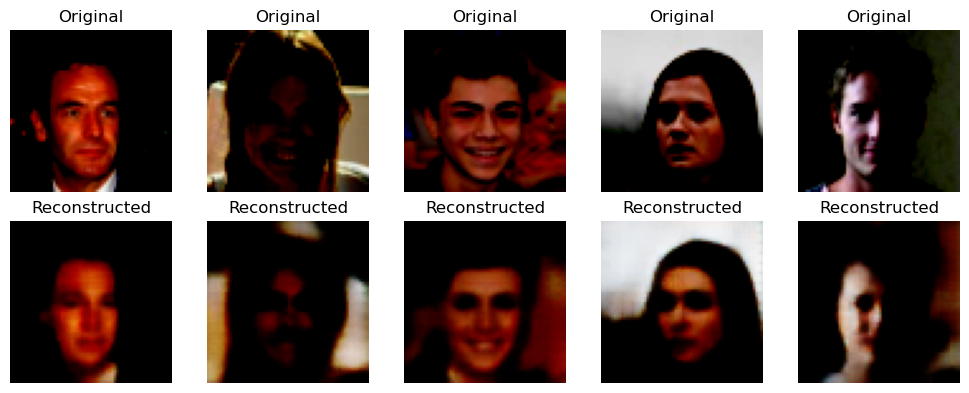

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Switch the model to evaluation mode
vae.eval()

# For visualizing images, select a few individual images
num_images_to_visualize = 5

# Track the total MSE
total_mse = 0.0
num_images = 0

# Visualization setup
fig, axes = plt.subplots(2, num_images_to_visualize, figsize=(10, 4))

with torch.no_grad():
    for i, data in enumerate(test_loader):
        if i >= num_images_to_visualize:
            break
        img = data.to(device)
        recon, _, _ = vae(img)

        # Calculate the MSE loss
        mse_loss = F.mse_loss(recon, img, reduction='sum').item()
        total_mse += mse_loss
        num_images += img.size(0)

        # Display original images
        axes[0, i].imshow(np.transpose(img[0].cpu().numpy(), (1, 2, 0)))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Display reconstructed images
        axes[1, i].imshow(np.transpose(recon[0].cpu().numpy(), (1, 2, 0)))
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

# Calculate the average MSE
average_mse = total_mse / num_images
print(f'Average MSE: {average_mse}')

plt.tight_layout()
plt.show()



In [ ]:
#### Now the Variational Autoencoder ######
class VAE(nn.Module):
    def __init__(self,latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(32, 64, 7)

        # This represents the fully connected layers that output the mean and log-variance
        self.fc_mu = nn.Linear(in_features=64*10*10, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=64*10*10, out_features=latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(in_features=latent_dim, out_features=64*10*10)
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, 7)
        self.dec_conv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = self.dec_fc(z)
        z = z.view(z.size(0), 64, 10, 10)  # Unflatten z to match the shape after the last conv layer in the encoder
        z = F.relu(self.dec_conv1(z))
        z = F.relu(self.dec_conv2(z))
        z = torch.sigmoid(self.dec_conv3(z))  # Sigmoid activation to get the output between 0 and 1
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


latent_dims = [20, 50, 80, 100, 200]  # Example range of latent dimensions
best_mse = float('inf')
best_dim = None

for dim in latent_dims:
    # Initialize a new VAE model with the current latent dimension
    vae = VAE(latent_dim=dim).to(device)

    # Define optimizer, loss function, etc.
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# And the training loop
for epoch in range(5):
    for data in train_loader:
        img = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{5}], Loss: {loss.item()/len(img):.4f}')

    # Evaluate the model
    vae.eval()
    total_mse = 0.0
    num_samples = 0
    with torch.no_grad():
        for data in test_loader:  # Assuming you have a validation_loader
            img = data.to(device)
            recon, _, _ = vae(img)
            mse_loss = F.mse_loss(recon, img, reduction='sum').item()
            total_mse += mse_loss
            num_samples += img.size(0)

    average_mse = total_mse / num_samples

    # Compare and store the best model
    if average_mse < best_mse:
        best_mse = average_mse
        best_dim = dim

print(f'Best Latent Dimension: {best_dim} with MSE: {best_mse}')


Best Latent Dimension: 80 with MSE: 8612.411646388115
